[MLFlow-like google sheet](https://docs.google.com/spreadsheets/d/1X5_V8c0CzkPfk0wnVsuiloA1XUAmAn0It348D7g2Keg/edit?usp=sharing)

[checkpoints](https://drive.google.com/drive/folders/1sWj_DeKAmR_NEJhgrX82c0i3PSozte8q?usp=sharing)

[data](https://drive.google.com/drive/folders/17-yHEC8OGWe_lIyqDCLdYZgxQVVgcxUu?usp=sharing)

# Importing

## Installation

In [ ]:
from typing import List
import sys

In [ ]:
def filter_files(file_list: List[str], filter_list: List[str]) -> List[str]:
    """
    Принимает список файлов, возвращает те, которые упомянуты
    в requirements (список filter_list)
    """
    filtered_list = []
    for fname in file_list:
        if any(fname.split('==')[0] in s for s in filter_list):
            filtered_list.append(fname)
    return filtered_list

In [ ]:
def build_requirements_file(before, after):
    !pip freeze > /content/requirements.txt

    # Get minimum requirements file
    mod_list = [m.split('.')[0] for m in after if not m in before]
    with open("/content/requirements.txt", "r") as f:
        req_list = f.read().split('\n')

    # Replace with package name and handle cases where import name is different to module name
    mod_name_list = [['sklearn', 'scikit-learn'], ['skimage', 'scikit-image']]
    mod_replace_list = [[x[1] for x in mod_name_list] if s in [x[0] for x in mod_name_list] else s for s in mod_list]
    filtered_list = filter_files(req_list, mod_replace_list)

    with open("/content/requirements.txt", 'w') as file:
        for item in filtered_list:
            file.writelines(item + '\n')

In [ ]:
before = [str(m) for m in sys.modules]

!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

exit(0)

after = [str(m) for m in sys.modules]
build_requirements_file(before, after)

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-s5tve41r
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-s5tve41r
  Resolved https://github.com/facebookresearch/fvcore.git to commit 4d14ad0a8eb3ec002c87e5d3421a0d498dccebcc
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-81h7aqr4
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-81h7aqr4
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 855.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65324 sha256=fa2348815b4a903d00c2b9e3b19ef2f522954f3dd62ad85b393442c78b405818
  S

## Imports

### Imports without detectron2

In [ ]:
import os
import json
import cv2
import random
import urllib
import shutil
import zipfile
from google.colab.patches import cv2_imshow

import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread, imsave
import time
import sys
from datetime import datetime
from pathlib import Path
import pandas as pd
import csv
from glob import glob

from scipy import signal, ndimage
from skimage import io, img_as_float32
from sklearn.linear_model import LinearRegression
from skimage.util import img_as_uint
from skimage.metrics import structural_similarity, peak_signal_noise_ratio as psnr

from astropy.visualization import simple_norm

import warnings
warnings.filterwarnings("ignore")

### Import detectron2

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data.datasets import register_coco_instances
from detectron2.checkpoint import Checkpointer

In [ ]:
class CocoTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"
    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# General Params

In [ ]:
model_path = Path("/content/gdrive/MyDrive/ppedet/checkpoints")
dataset_path = Path("/content/gdrive/MyDrive/ppe_detection/")

## Load datasets

In [ ]:
labels = "ppe,glasses,glove,hood,mask,no_glasses,no_glove,no_hood,no_mask,no_shoe,no_suit,shoe,suit"
list_of_labels = labels.split(",")
number_of_labels = len(list_of_labels)

with open('/content/labels.txt', 'w') as f:
    for item in list_of_labels:
        print(item, file=f)

In [ ]:
for subset in ("train", "test", "valid"):
    register_coco_instances("ppe_dataset_%s" % subset, {}, str(dataset_path / subset / "_annotations.coco.json"), str(dataset_path / subset))

# Training

In [ ]:
#@markdown ## Visualize train dataset

ds_train_metadata = MetadataCatalog.get("ppe_dataset_train")
ds_dicts = DatasetCatalog.get("ppe_dataset_train")

for d in random.sample(ds_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ds_train_metadata, instance_mode=ColorMode.SEGMENTATION, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Training params initialization

In [ ]:
#@markdown ### Initialize train params

model_name = "frcnn_ppe_11" #@param {type: "string"}
full_model_path = model_path / model_name

h5_file_path = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml" #@param {type:"string"}
BATCH_SIZE = 4 #@param {type:"number"}
LEARNING_RATE = 0.01 #@param {type:"raw"}
GAMMA = 0.2 #@param {type:"number"}
MAX_SIZE_TRAIN = 256 #@param {type:"number"}
BATCH_SIZE_PER_IMAGE = 128 #@param {type:"number"}
AMP_ENABLE = False #@param {type:"boolean"}
NUM_EPOCHS = 45 #@param {type:"number"}
TRAIN_SIZE = len(glob(MetadataCatalog.get("ppe_dataset_train").image_root + "/*.jpg"))
MAX_ITER = int(TRAIN_SIZE / BATCH_SIZE * NUM_EPOCHS)
TEST_PERIOD = int(TRAIN_SIZE / BATCH_SIZE) * 3
resume_training = False #@param {type: "boolean"}
SOLVER_STEPS = [2500,5000,6500] #@param {type:"raw"}
WARMUP_ITER = 1000 #@param {type:"integer"}

In [ ]:
#@markdown ### Initialize cfg

cfg = get_cfg()

if not resume_training:
    cfg.merge_from_file(model_zoo.get_config_file(h5_file_path))

    cfg.DATASETS.TRAIN = ("ppe_dataset_train",)
    cfg.DATASETS.TEST = ("ppe_dataset_valid",)
    cfg.OUTPUT_DIR= str(full_model_path)
    cfg.DATALOADER.NUM_WORKERS = 4
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(h5_file_path)
    cfg.SOLVER.IMS_PER_BATCH = BATCH_SIZE
    cfg.SOLVER.BASE_LR = LEARNING_RATE
    cfg.SOLVER.WARMUP_ITERS = WARMUP_ITER
    cfg.SOLVER.MAX_ITER = MAX_ITER
    cfg.SOLVER.STEPS = SOLVER_STEPS
    cfg.SOLVER.GAMMA = GAMMA
    cfg.INPUT.MAX_SIZE_TRAIN = MAX_SIZE_TRAIN
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = BATCH_SIZE_PER_IMAGE
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = number_of_labels
    cfg.TEST.EVAL_PERIOD = TEST_PERIOD
    cfg.SOLVER.AMP.ENABLED = AMP_ENABLE
    cfg.SOLVER.CHECKPOINT_PERIOD = TEST_PERIOD * 15
else:
    cfg.merge_from_file(full_model_path / "config.yaml")

In [ ]:
#@markdown ## Create folder structure

if not resume_training:
    if full_model_path.exists():
        shutil.rmtree(str(full_model_path))
    os.makedirs(full_model_path)
    shutil.copy("/content/labels.txt", str(full_model_path / "labels.txt"))

## Training

In [ ]:
start = time.time()

print(cfg.dump())

trainer = CocoTrainer(cfg)

trainer.resume_or_load(resume=resume_training)
trainer.train()

with (full_model_path / "config.yaml").open('w', encoding='utf-8') as cfg_file:
    cfg_file.writelines(cfg.dump())

dt = time.time() - start
mins, sec = divmod(dt, 60)
hour, mins = divmod(mins, 60)
print(f"Time elapsed: {hour} hour(s), {mins} min(s), {round(sec)} sec(s)")

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - ppe_dataset_valid
  TRAIN:
  - ppe_dataset_train
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 256
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: buil

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[07/16 12:00:44 d2.engine.train_loop]: Starting training from iteration 0
[07/16 12:00:51 d2.utils.events]:  eta: 0:36:39  iter: 19  total_loss: 4.054  loss_cls: 2.333  loss_box_reg: 0.8692  loss_rpn_cls: 0.6873  loss_rpn_loc: 0.1992    time: 0.2656  last_time: 0.4141  data_time: 0.0726  last_data_time: 0.0097   lr: 0.00019981  max_mem: 4664M
[07/16 12:00:57 d2.utils.events]:  eta: 0:38:29  iter: 39  total_loss: 2.341  loss_cls: 1.084  loss_box_reg: 0.9069  loss_rpn_cls: 0.2136  loss_rpn_loc: 0.1548    time: 0.2855  last_time: 0.2747  data_time: 0.0338  last_data_time: 0.0391   lr: 0.00039961  max_mem: 4664M
[07/16 12:01:02 d2.utils.events]:  eta: 0:37:45  iter: 59  total_loss: 1.968  loss_cls: 0.8675  loss_box_reg: 0.8893  loss_rpn_cls: 0.105  loss_rpn_loc: 0.1017    time: 0.2767  last_time: 0.2258  data_time: 0.0247  last_data_time: 0.0197   lr: 0.00059941  max_mem: 4664M
[07/16 12:01:08 d2.utils.events]:  eta: 0:37:53  iter: 79  total_loss: 1.825  loss_cls: 0.731  loss_box_reg: 0.84

# Test

## Metrics Visualization

In [ ]:
#@markdown ### Import just for cell

import json
from matplotlib import pyplot as plt

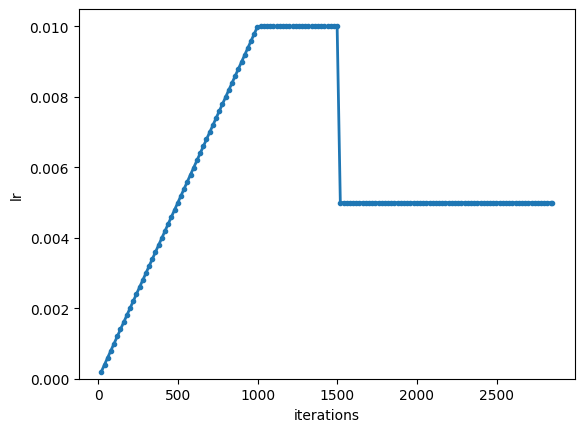

In [ ]:
#@markdown Visualize metrics by iterations
key = "lr" #@param ['fast_rcnn/cls_accuracy', 'fast_rcnn/false_negative', 'fast_rcnn/fg_cls_accuracy', 'loss_box_reg', 'loss_cls', 'loss_rpn_cls', 'loss_rpn_loc', 'lr', 'roi_head/num_bg_samples', 'roi_head/num_fg_samples', 'rpn/num_neg_anchors', 'rpn/num_pos_anchors', 'total_loss']
model_name = "frcnn_ppe_09" #@param {type:"string"}

iterations = []
values = []
with open(model_path / model_name / "metrics.json") as f:
    for s in f:
        d = json.loads(s)
        if key in d:
            iterations.append(d["iteration"])
            values.append(d[key])

fig, ax = plt.subplots()
ax.plot(iterations, values, linewidth=2.0, marker='.')

ax.set_xlabel("iterations")
ax.set_ylabel(key)
ax.set_ylim(ymin=0)
ax.ticklabel_format(useOffset=False, style='plain')

plt.show()

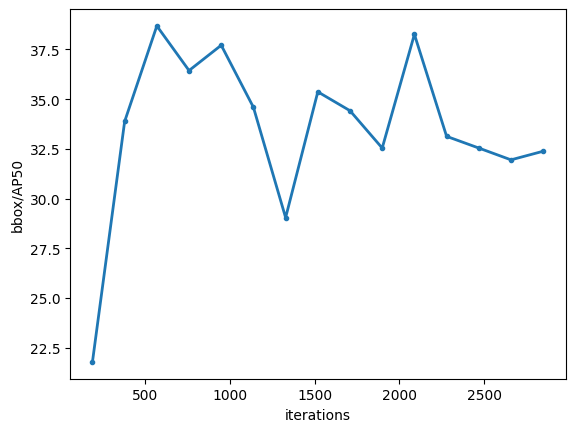

In [ ]:
#@markdown Visualize metrics by evaluations
key = "bbox/AP50" #@param ['bbox/AP', 'bbox/AP-glasses', 'bbox/AP-glove', 'bbox/AP-hood', 'bbox/AP-mask', 'bbox/AP-no_glasses', 'bbox/AP-no_glove', 'bbox/AP-no_hood', 'bbox/AP-no_mask', 'bbox/AP-no_shoe', 'bbox/AP-no_suit', 'bbox/AP-ppe', 'bbox/AP-shoe', 'bbox/AP-suit', 'bbox/AP50', 'bbox/AP75', 'bbox/APl', 'bbox/APm', 'bbox/APs']
model_name = "frcnn_ppe_09" #@param {type:"string"}

iterations = []
values = []
with open(model_path / model_name / "metrics.json") as f:
    for s in f:
        d = json.loads(s)
        if key in d:
            iterations.append(d["iteration"])
            values.append(d[key])

fig, ax = plt.subplots()
ax.plot(iterations, values, linewidth=2.0, marker='.')

ax.set_xlabel("iterations")
ax.set_ylabel(key)
ax.ticklabel_format(useOffset=False, style='plain')

plt.show()

# MLFlow Loading

In [ ]:
# Connect MLFlow
mlflow.set_tracking_uri("http://localhost:9002")
mlflow.set_experiment("FasterRCNN PPE detection")

2023/07/17 12:00:10 INFO mlflow.tracking.fluent: Experiment with name 'FasterRCNN PPE detection' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/6', creation_time=1689584410784, experiment_id='6', last_update_time=1689584410784, lifecycle_stage='active', name='FasterRCNN PPE detection', tags={}>

In [ ]:
MODEL_NAME = "frcnn_ppe_11"

In [ ]:
mlflow.start_run(run_name=MODEL_NAME)
mlflow.set_tag("mlflow.note.content", "To restore see: https://colab.research.google.com/drive/14z94Nqh05EXbK4yKWxthxcrhHaaNe-Tz?usp=sharing")

In [ ]:
with open(model_path / MODEL_NAME / "metrics.json") as f:
    for s in f:
        d = json.loads(s)
        for key in d.keys():
            if key in ["iteration", "data_time", "eta_seconds", "time"]:
                continue
            s = "train/%s" if not key.startswith("bbox") else "val/%s"
            mlflow.log_metric(s % key, d[key], step=d['iteration'])

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(str(model_path / MODEL_NAME / "config.yaml"))
cfg.DATASETS.TEST = ("ppe_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = str(model_path / MODEL_NAME / "model_final.pth")
cfg.OUTPUT_DIR = str(model_path / MODEL_NAME)

In [ ]:
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("ppe_dataset_test", output_dir=model_path / MODEL_NAME / "test_preds")
test_set_loader = build_detection_test_loader(cfg, "ppe_dataset_test")

evaluation_results = inference_on_dataset(predictor.model, test_set_loader, evaluator)

[07/17 12:25:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Загрузки/ppedet/checkpoints/frcnn_ppe_11/model_final.pth ...
WARNING [07/17 12:25:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/17 12:25:34 d2.data.datasets.coco]: Loaded 126 images in COCO format from Загрузки/ppe_detection/test/_annotations.coco.json
[07/17 12:25:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/17 12:25:34 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/17 12:25:34 d2.data.common]: Serializing 126 elements to byte tensors and concatenating them all ...
[07/17 12:25:34 d2.data.common]: Serialized dataset takes 0.06 MiB
[07/17 12:25:34 d2.evaluation.evaluator]: Start inference on 126 batches
[07/17 12:25:37 d2.evaluation.evaluator]

In [ ]:
for k, v in evaluation_results["bbox"].items():
    mlflow.log_metric("test/%s" % k, v, step=0)

In [ ]:
mlflow.log_artifacts(str(model_path / MODEL_NAME))

In [ ]:
mlflow.end_run()